# Q1. In order to predict house price based on several characteristics, such as location, square footage, number of bedrooms, etc., you are developing an SVM regression model. Which regression metric in this situation would be the best to employ?

## Dataset link:_https:/Idrive.googIe.com/fiIe/d/1Z90Lpmt61DRNw71eNcHYTGeJ RYypRSCO/view?usp=share_link

In [1]:
#Let's start with importing necessary libraries
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Importing the dataset

In [2]:
df = pd.read_csv(r"C:\Users\milan\Documents\Data Science\skills\Notes\Pandas_\New Assq\Bengaluru_House_Data.csv")

In [3]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


# Feature Engineering

<AxesSubplot: >

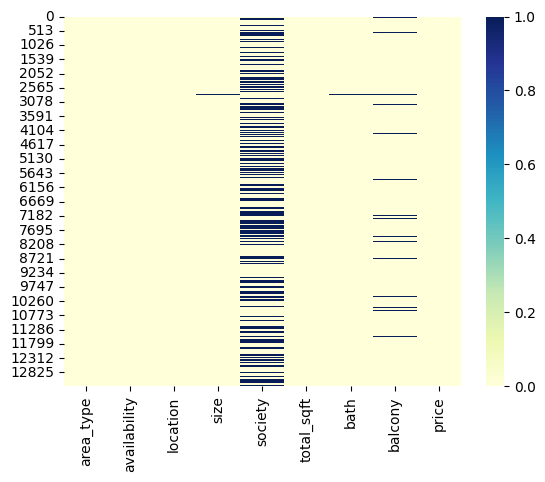

In [4]:
# Visualize missing values using a heatmap
sns.heatmap(df.isnull(), cmap='YlGnBu')

In [5]:
# Checking the duplicate values in my df
df.duplicated().sum()

529

In [6]:
# dropping the duplicate values
df = df.drop_duplicates()

In [7]:
mode_size = df['size'].mode()[0]
mode_society = df['society'].mode()[0]
mode_bath = df['bath'].mode()[0]
mode_balcony = df['balcony'].mode()[0]

df['size'].fillna(mode_size, inplace=True)
df['society'].fillna(mode_society, inplace=True)
df['bath'].fillna(mode_bath, inplace=True)
df['balcony'].fillna(mode_balcony, inplace=True)

<AxesSubplot: >

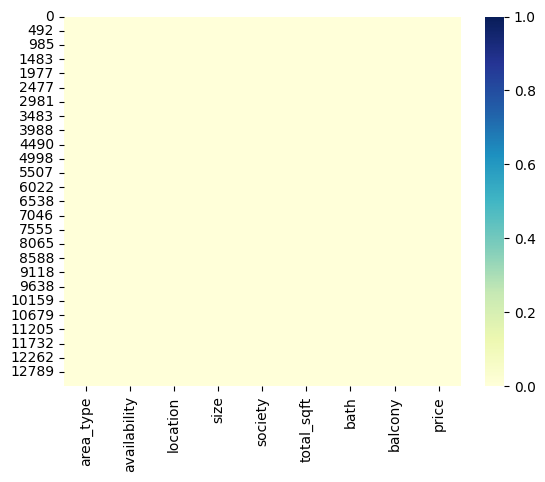

In [8]:
# Visualize missing values using a heatmap
sns.heatmap(df.isnull(), cmap='YlGnBu')

In [9]:
df.nunique()

area_type          4
availability      81
location        1305
size              31
society         2688
total_sqft      2117
bath              19
balcony            4
price           1994
dtype: int64

In [10]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [11]:
df['size'].str.split(' ').str[0]
df['size'].str.split(' ').str[1]

0            BHK
1        Bedroom
2            BHK
3            BHK
4            BHK
          ...   
13314        BHK
13315    Bedroom
13316        BHK
13317        BHK
13318        BHK
Name: size, Length: 12791, dtype: object

In [12]:
df['bedrooms'] = df['size'].str.split(' ').str[0].astype(int)

In [13]:
df.drop(columns='size', inplace=True)

In [14]:
import re

# Define a function to extract numerical values from string using regex
def extract_number(text):
    match = re.findall('\d+', str(text))
    if match:
        return int(match[0])
    else:
        return None

# Apply the function to 'total_sqft' column to create a new 'sqft' column
df['sqft'] = df['total_sqft'].apply(extract_number)

# Drop rows with null values in the 'sqft' column
df.dropna(subset=['sqft'], inplace=True)


In [15]:
df.drop(columns= 'availability', inplace=True)


In [16]:
df.drop(columns='total_sqft', inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12791 entries, 0 to 13318
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   area_type  12791 non-null  object 
 1   location   12790 non-null  object 
 2   society    12791 non-null  object 
 3   bath       12791 non-null  float64
 4   balcony    12791 non-null  float64
 5   price      12791 non-null  float64
 6   bedrooms   12791 non-null  int32  
 7   sqft       12791 non-null  int64  
dtypes: float64(3), int32(1), int64(1), object(3)
memory usage: 849.4+ KB


In [18]:
df['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [19]:
df['location'].unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [20]:
df['society'].unique()

array(['Coomee ', 'Theanmp', 'GrrvaGr', ..., 'SJovest', 'ThhtsV ',
       'RSntsAp'], dtype=object)

In [21]:
# Compute mean price for each area_type
area_type_prices = df.groupby('area_type')['price'].mean().to_dict()
location_type_prices = df.groupby('location')['price'].mean().to_dict()
society_type_prices = df.groupby('society')['price'].mean().to_dict()

# Map the mean prices to the area_type categories
df['area_type_encoded'] = df['area_type'].map(area_type_prices)
df['location_type_encoded'] = df['location'].map(location_type_prices)
df['society_type_encoded'] = df['society'].map(society_type_prices)

# Drop the original area_type column
df.drop('area_type', axis=1, inplace=True)
df.drop('location', axis=1, inplace=True)
df.drop('society', axis=1, inplace=True)

In [22]:
df['bath'] = df['bath'].astype(int)
df['balcony'] = df['balcony'].astype(int)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12791 entries, 0 to 13318
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bath                   12791 non-null  int32  
 1   balcony                12791 non-null  int32  
 2   price                  12791 non-null  float64
 3   bedrooms               12791 non-null  int32  
 4   sqft                   12791 non-null  int64  
 5   area_type_encoded      12791 non-null  float64
 6   location_type_encoded  12790 non-null  float64
 7   society_type_encoded   12791 non-null  float64
dtypes: float64(4), int32(3), int64(1)
memory usage: 749.5 KB


In [24]:
df.dropna(inplace=True)

In [25]:
#define numerical and catagorical columns
num_features = [features for features in df.columns if df[features].dtype != 'O']
cat_features = [features for features in df.columns if df[features].dtype == 'O']


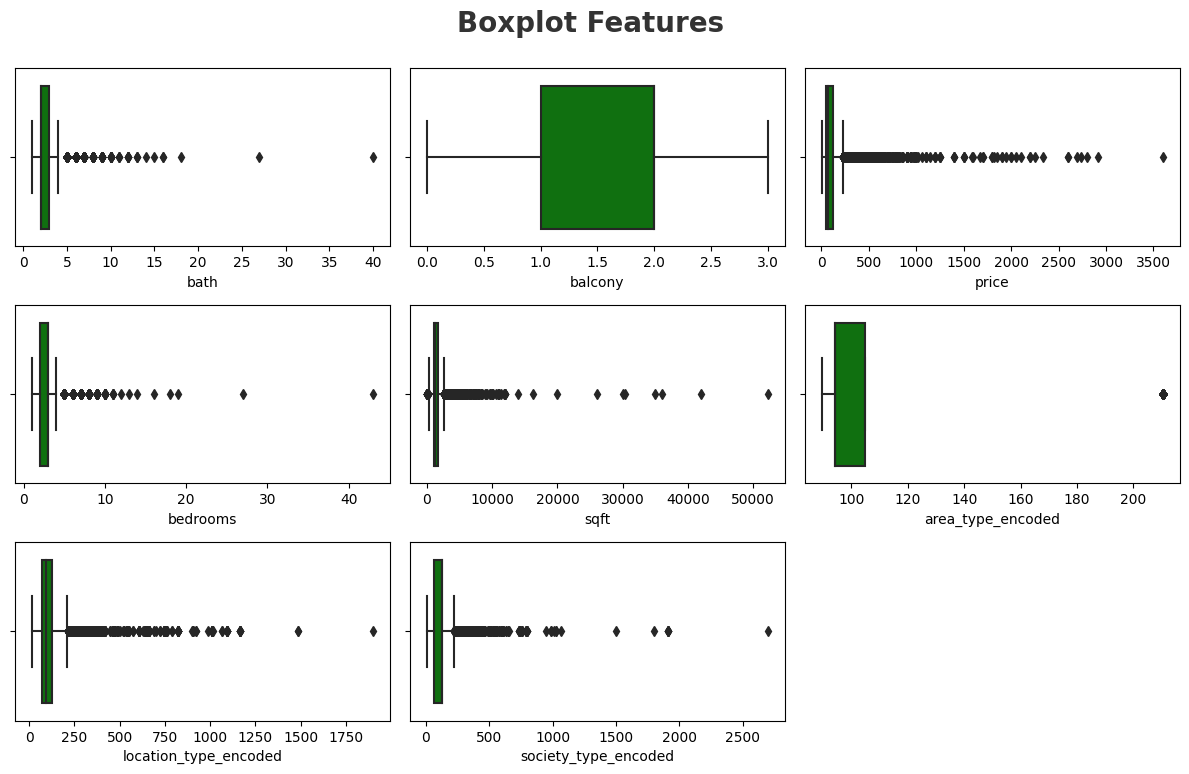

In [26]:
# Boxplot to find out the outlier
plt.figure(figsize=(12,12))
plt.suptitle("Boxplot Features ",fontsize = 20, fontweight = 'bold',alpha = 0.8, y =1)

for i in range (0,len(num_features)):
    plt.subplot(5,3,i+1)
    sns.boxplot(x = df[num_features[i]],color = 'g')
    plt.xlabel(num_features[i])
    plt.tight_layout()
    

# Feature Selection

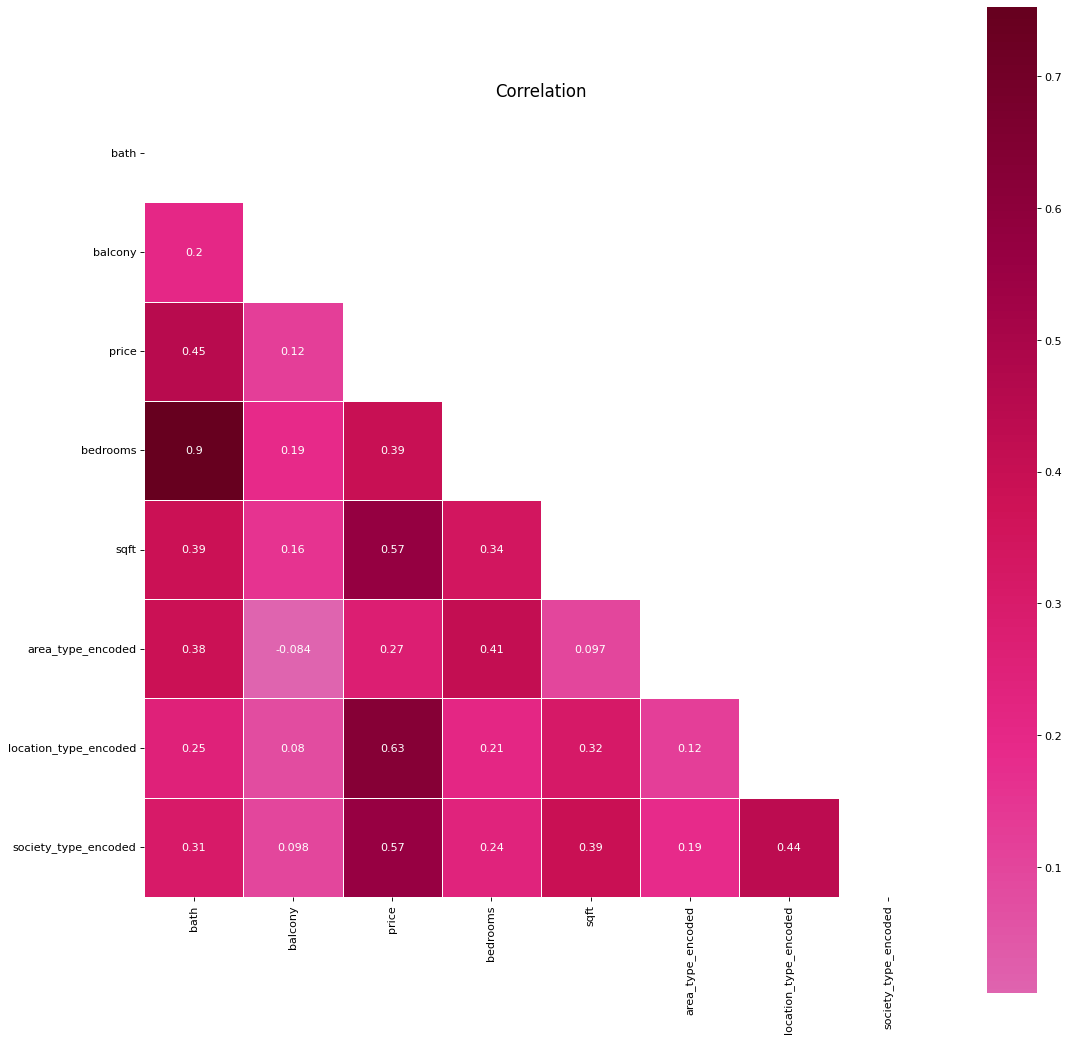

In [27]:
plt.figure(figsize=(16,16),dpi=80)
corr=df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask, cmap='PuRd', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation', fontsize=15)
plt.show()

In [28]:
#segregate the dependent and independent variable
X = df.drop(columns = ['price'])
y = df['price']

In [29]:
X.isna().sum()

bath                     0
balcony                  0
bedrooms                 0
sqft                     0
area_type_encoded        0
location_type_encoded    0
society_type_encoded     0
dtype: int64

In [30]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9592, 7), (3198, 7), (9592,), (3198,))

In [31]:
def scaler_standard_outlier(X_train, X_test):
    #scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    #removing outliers
    Q1 = X_train.quantile(0.25)
    Q3 = X_train.quantile(0.75)
    IQR = Q3 - Q1
    X_train_out = X_train.copy()
    X_test_out = X_test.copy()
    for col in X_train.columns:
        # Replace values below Q1 - 1.5*IQR with the median value
        X_train_out.loc[X_train_out[col] < (Q1[col] - 1.5*IQR[col]), col] = X_train[col].median()
        X_test_out.loc[X_test_out[col] < (Q1[col] - 1.5*IQR[col]), col] = X_train[col].median()
        # Replace values above Q3 + 1.5*IQR with the median value
        X_train_out.loc[X_train_out[col] > (Q3[col] + 1.5*IQR[col]), col] = X_train[col].median()
        X_test_out.loc[X_test_out[col] > (Q3[col] + 1.5*IQR[col]), col] = X_train[col].median()
    
    return X_train_out, X_test_out


In [32]:
X_train_out, X_test_out = scaler_standard_outlier(X_train, X_test)

In [33]:
%time


# Define parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}


# Create SVR model
svr = SVR()

# Perform GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
grid_search.fit(X_train_out, y_train)

# Print best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters:  {'kernel': 'linear'}
Best score:  -19871.05280163183


In [34]:
"""
%time


# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 0.5],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4, 1e-5],
    'epsilon': [0.1, 0.2, 0.5, 1.0],
    'max_iter': [-1, 1000, 5000, 10000]
}


# Create SVR model
svr = SVR()

# Perform GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
grid_search.fit(X_train_out, y_train)

# Print best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

"""

'\n%time\n\n\n# Define parameter grid\nparam_grid = {\n    \'C\': [0.1, 1, 10, 100],\n    \'gamma\': [\'scale\', \'auto\'],\n    \'kernel\': [\'linear\', \'poly\', \'rbf\', \'sigmoid\'],\n    \'degree\': [2, 3, 4],\n    \'coef0\': [0.0, 0.1, 0.5],\n    \'shrinking\': [True, False],\n    \'tol\': [1e-3, 1e-4, 1e-5],\n    \'epsilon\': [0.1, 0.2, 0.5, 1.0],\n    \'max_iter\': [-1, 1000, 5000, 10000]\n}\n\n\n# Create SVR model\nsvr = SVR()\n\n# Perform GridSearchCV\ngrid_search = GridSearchCV(svr, param_grid, cv=5, scoring=\'neg_mean_squared_error\', n_jobs=-1, verbose=3)\ngrid_search.fit(X_train_out, y_train)\n\n# Print best parameters and score\nprint("Best parameters: ", grid_search.best_params_)\nprint("Best score: ", grid_search.best_score_)\n\n'

In [ ]:
grid_search.best_params_

{'kernel': 'linear'}

In [38]:
## SVC prediction
y_pred = grid_search.predict(X_test_out)

In [39]:
y_pred

array([ 23.68802453,  62.62980581,  88.69708461, ..., 103.10069529,
       115.70868779,  94.92855797])

In [45]:
# Calculate RMSE on validation set using best estimator
best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test_out)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE on validation set using best estimator: ", rmse)

RMSE on validation set using best estimator:  143.42618746360912


In [46]:
print("MSE: ", -grid_search.best_score_)

MSE:  19871.05280163183


# Q2. You have built an SVM regression model and are trying to decide between using MSE or R-squared as your evaluation metric. Which metric would be more appropriate if your goal is to predict the actual price of a house as accurately as possible?


>In this scenario, using RMSE (Root Mean Squared Error) would be a more appropriate evaluation metric if the goal is to predict the actual price of a house as accurately as possible.

>MSE (Mean Squared Error) measures the average squared difference between the predicted and actual values. However, it doesn't give a clear picture of how much the predictions are off by, as the units of the error are squared units of the target variable. In contrast, RMSE is a more interpretable metric, as it is in the same units as the target variable, and therefore provides a better sense of how far the predictions are from the actual values.

>Thus, for the specific goal of predicting the actual price of a house, where the actual price is in units of dollars, RMSE would be a better metric to use for evaluating the performance of the SVM regression model.

# Q3. You have a dataset with a significant number of outliers and are trying to select an appropriate regression metric to use with your SVM model. Which metric would be the most appropriate in this scenario?

>In a scenario with a significant number of outliers, it would be appropriate to use a robust regression metric that is less sensitive to outliers. One such metric is the Mean Absolute Error (MAE), which measures the average absolute difference between the predicted and actual values. Unlike the Mean Squared Error (MSE), which heavily penalizes large errors, the MAE is less affected by outliers and provides a more accurate representation of the overall model performance. Therefore, MAE would be the most appropriate regression metric to use in this scenario.

# Q4. You have built an SVM regression model using a polynomial kernel and are trying to select the best metric to evaluate its performance. You have calculated both MSE and RMSE and found that both values are very close. Which metric should you choose to use in this case?

>In this case, it is recommended to use RMSE as it is more interpretable compared to MSE because it is in the same unit as the target variable. Moreover, RMSE penalizes large errors more heavily than smaller errors which can be particularly important in regression tasks where outliers or large errors can have a significant impact on the model's performance.

# Q5. You are comparing the performance of different SVM regression models using different kernels (linear, polynomial, and RBF) and are trying to select the best evaluation metric. Which metric would be most appropriate if your goal is to measure how well the model explains the variance in the target variable?

>If the goal is to measure how well the model explains the variance in the target variable, then the most appropriate evaluation metric to use is the coefficient of determination, R-squared (R²). R-squared measures the proportion of variance in the target variable that can be explained by the model, with a value of 1 indicating a perfect fit and a value of 0 indicating that the model explains none of the variability in the target variable. It is a commonly used metric in regression analysis and can be used to compare the performance of models with different kernels.